# Detección de Inyecciones SQL mediante técnicas de procesamiento de lenguaje natural y aprendizaje automático

## Introducción
Por Gonzalo Benito, Lic. en Sistemas de Información, Universidad Nacional de Luján, Argentina

Este trabajo propone desarrollar un sistema de detección de ataques de Inyección SQL utilizando técnicas de procesamiento de lenguaje natural (NLP) y algoritmos de machine learning. Se empleará un dataset obtenido de Kaggle que contiene sentencias SQL etiquetadas como vulnerables o benignas. La metodología se centrará en convertir el texto en embeddings utilizando el algoritmo Word2Vec, y posteriormente aplicar modelos de clasificación secuencial como el algoritmo Conditional Random Fields (CRF), probando diferentes configuraciones, junto con otros algoritmos de Machine Learning de clasificación, como Support Vector Machines (SVM) y Logistic Regression. El objetivo es evaluar y comparar el desempeño mediante medidas de precisión como Accuracy y curva ROC, y demostrar cómo el preprocesamiento de texto mediante embeddings y la aplicación de modelo de Machine Learning pueden mejorar la detección de vulnerabilidades SQL en sistemas web.

## Importación e instalación de librerías

In [186]:
%pip install gensim sklearn_crfsuite pandas numpy nltk

Note: you may need to restart the kernel to use updated packages.


In [187]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import sklearn_crfsuite
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

from IPython.display import display     # Para mostrar dataframes en formato de tabla

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Importación del dataset y selección de features

In [188]:
# Cargar el dataset de SQL Injection
data = pd.read_csv("/data/SQLiV3.csv")  # El dataset debe tener columnas 'Sentence' y 'Label'
data = data[['Sentence', 'Label']]  # Seleccionar solo las columnas necesarias
data['Sentence'] = data['Sentence'].astype(str)
print(data.head())

                                            Sentence Label
0                  " or pg_sleep  (  __TIME__  )  --     1
1  create user name identified by pass123 tempora...   NaN
2   AND 1  =  utl_inaddr.get_host_address   (    ...     1
3   select * from users where id  =  '1' or @ @1 ...     1
4   select * from users where id  =  1 or 1#"  ( ...     1


## Preprocesamiento

### Limpieza de missing values y ruido

In [189]:
# Eliminar filas donde 'Sentence' es null
data = data.dropna(subset=['Sentence'])

# Me quedo solo con las clases 0 y 1 (por si hay algún otro valor en 'Label', como un string, o si hay nulos)
data = data[data['Label'].isin(['0', '1'])]

print(data.head())

                                            Sentence Label
0                  " or pg_sleep  (  __TIME__  )  --     1
2   AND 1  =  utl_inaddr.get_host_address   (    ...     1
3   select * from users where id  =  '1' or @ @1 ...     1
4   select * from users where id  =  1 or 1#"  ( ...     1
5   select name from syscolumns where id   =     ...     1


### Tokenización
Source: https://openwebinars.net/blog/tecnicas-clave-para-procesamiento-texto-nlp/

In [190]:
# Generación de tokens con NLTK (Natural Language Toolkit)
data['Tokens'] = data['Sentence'].apply(word_tokenize)  # toma una cadena de texto (Sentence) y la divide en una lista de palabras o tokens
sentences = data['Tokens'].tolist()

for i, sentence in enumerate(sentences[8:15], start=8):
    print(f"Sentence {i}: {sentence}")
print("Sentence n: ...")

Sentence 8: ['select', '*', 'from', 'users', 'where', 'id', '=', "'", '1', "'", 'or', '\\.', '<', '\\', 'union', 'select', '1', ',', '@', '@', 'VERSION', '--', '1', "'"]
Sentence 9: ['?', 'or', '1', '=', '1', '--']
Sentence 10: [')', 'or', '(', "'", 'a', "'", '=', "'", 'a']
Sentence 11: ['admin', "'", 'or', '1', '=', '1', '#']
Sentence 12: ['select', '*', 'from', 'users', 'where', 'id', '=', '1', 'or', '``', '(', ']', "''", 'or', '1', '=', '1', '--', '1']
Sentence 13: ['or', '1', '=', '1', '--']
Sentence 14: ['AND', '1', '=', 'utl_inaddr.get_host_address', '(', '(', 'SELECT', 'DISTINCT', '(', 'column_name', ')', 'FROM', '(', 'SELECT', 'DISTINCT', '(', 'column_name', ')', ',', 'ROWNUM', 'AS', 'LIMIT', 'FROM', 'all_tab_columns', ')', 'WHERE', 'LIMIT', '=', '5', ')', ')', 'AND', "'", 'i', "'", '=', "'", 'i']
Sentence n: ...


### Generación de embeddings con el algoritmo Word2Vec

In [191]:
# Generación de embeddings con Word2Vec
# Source: https://radimrehurek.com/gensim/models/word2vec.html

# TO DO: Cambiar vector_size a 100
embedding_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)    # Crea el modelo a partir de las sentencias tokenizadas

# Explicacion de los parámetros:
# vector_size = dimensiones del vector de embeddings -> por ejemplo, el vector de embeddings de la palabra 'SELECT' podría ser [i1, i2, i3, ..., i100]
# window = tamaño de ventana de contexto -> word1 word2 word3 word4 word5 OBJETIVO word6 word7 word8 word9 word10
# min_count = cantidad mínima de veces que una palabra debe aparecer en el corpus para ser considerada
# workers = cantidad de hilos de ejecución para entrenar el modelo

# Diccionario de embeddings -> [palabra => vector de embeddings]   Ejemplo: embeddings['SELECT'] = [0.1, 0.2, 0.3, ..., 0.1]
# Source: https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html
embeddings = {}
print(embedding_model.wv.index_to_key)  # Vocabulary list -> tiene todas las palabras que se encuentran en el corpus (sin repetir)
for word in embedding_model.wv.index_to_key:
    embeddings[word] = embedding_model.wv[word] # Obtiene el vector de embeddings del lexema 'word'

print(embeddings['SELECT'])

[')', '(', '=', ',', "'", 'SELECT', 'FROM', 'select', '*', '1', 'and', '||chr', 'as', 'null', "''", 'WHERE', 'from', 'where', '--', '113', 'or', '``', '%', 'union', '#', '||char', '+char', 'all', 'char', 'end', 'else', 'then', 'case', 'when', '3', 'count', '122', 'AND', '0', 's', 'AS', 'sysusers', '@', '$', 'BY', 'all_users', '5', 'NOT', 'elt', 'ORDER', 'like', 'JOIN', 'rdb', 'TOP', 't2', 't3', 't1', 'dual', 'sleep', 'concat', 'chr', '112', 'BETWEEN', 'ROWS', 'FIRST', 'FETCH', '106', '+', 'COUNT', '118', 'AVG', '50', 'PERCENT', '||', 'sysibm.systables', 'ONLY', 'x', 'repeat', ',0', 'regexp_substring', ',0x717a767a71', 'UNION', 'IN', '65', '0x7171706a71', 'ON', 'by', 'LIMIT', 'id', 't4', 'users', 'LIKE', '2', 'SUM', 'DISTINCT', ';', '[', ']', ',500000000', '69', "1'+", "1'||", 'upper', 'OR', 'benchmark', '83', 'ASC', 'md5', '5000000', 'a', 'de', 'right', 'left', 'rlike', 'floor', 'group', '.', 'crypt_key', 'generate_series', 'in', 'ID', 'rand', 'City', 'post_id', 'extractvalue', 'NULL',

In [192]:
# Convertir las oraciones en secuencias de embeddings
def sentence_to_embeddings(sentence):
    return [embeddings[word] for word in sentence if word in embeddings]    # Por cada fila del dataset, obtiene el vector de embeddings de cada palabra en la oración, y lo guarda en una lista. Luego retorna la lista de vectores. En caso de que la palabra no esté en el diccionario de embeddings, no se considera, evitando errores y nulos.

data['Embeddings'] = data['Tokens'].apply(sentence_to_embeddings)
print(len(data['Embeddings']) == len(data['Label']))
display(data['Embeddings'].head())
# display(data.head())

True


0    [[2.493872, 1.8701782, 2.2499359, 0.7249025, 0...
2    [[2.8590941, -1.1079504, 2.266345, -1.3036536,...
3    [[1.4968561, -0.38216618, 2.6126523, 2.1085498...
4    [[1.4968561, -0.38216618, 2.6126523, 2.1085498...
5    [[1.4968561, -0.38216618, 2.6126523, 2.1085498...
Name: Embeddings, dtype: object

## Aplicar modelos de clasificación secuencial

### Conditional Random Fields (CRF)
API Docs: # https://sklearn-crfsuite.readthedocs.io/en/latest/api.html

In [193]:
# Preparar los datos para CRF
X = data['Embeddings'].to_list()
Y = data['Label']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)   # Separo los datos en entrenamiento y prueba, manteniendo la distribución de las clases para ambos conjuntos

In [194]:
# Convertir las secuencias de embeddings en un formato que el modelo CRF pueda manejar

# X (list of lists of dicts) – Feature dicts for several documents (in a python-crfsuite format).
# Y (list of lists of strings) – Labels for several documents.


def convert_embeddings_to_features(embeddings):
    '''La función toma una lista de embeddings (una sentence) y la convierte en una lista de diccionarios, donde cada diccionario representa un vector de características para una palabra.
    Cada clave del diccionario sigue el formato dim_{i}, donde i es el índice de la dimensión del embedding, y el valor es el valor correspondiente del embedding convertido a tipo float.
    '''
    return [{f'dim_{i}': float(value) for i, value in enumerate(word)} for word in embeddings]

X_train_features = [convert_embeddings_to_features(sentence) for sentence in X_train]   # Ejemplo: X_train_features[0] = [{'dim_0': 0.1, 'dim_1': 0.2, ..., 'dim_99': 0.1}, {'dim_0': 0.2, 'dim_1': 0.3, ..., 'dim_99': 0.2}, ...]
X_test_features = [convert_embeddings_to_features(sentence) for sentence in X_test]

# Asegura que cada secuencia en X_train_features tenga una secuencia correspondiente de etiquetas en Y_train.
Y_train_sequences = [[label] * len(sentence) for sentence, label in zip(X_train, Y_train)]
Y_test_sequences = [[label] * len(sentence) for sentence, label in zip(X_test, Y_test)]

# Por qué se hace esto? Porque el modelo CRF necesita que las secuencias de características y etiquetas tengan la misma longitud.
# Por ejemplo, si la oración "SELECT * FROM users" tiene 4 palabras, y la etiqueta de esa sentence es 1, entonces la secuencia de etiquetas sería [1, 1, 1, 1].
# De esta forma, el modelo CRF puede aprender que la etiqueta 1 se aplica a todas las palabras o  tokens de la oración.

# El modelo CRF está diseñado para tareas de etiquetado secuencial, es decir, para predecir una etiqueta para cada token en una secuencia. En este caso, dado que el dataset solo tiene una etiqueta global por sentencia, se asume que cada token de la sentencia comparte esa etiqueta. Por eso, se repite el label para cada token.

print(len(X_train_features) == len(Y_train_sequences))

True


In [195]:
# Entrenar el modelo CRF
# https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html#training
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train_features, Y_train_sequences)

# Evaluar el modelo
y_pred = crf.predict(X_test_features)

## Resultados

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     37306
           1       0.99      1.00      0.99     73307

    accuracy                           0.99    110613
   macro avg       0.99      0.99      0.99    110613
weighted avg       0.99      0.99      0.99    110613



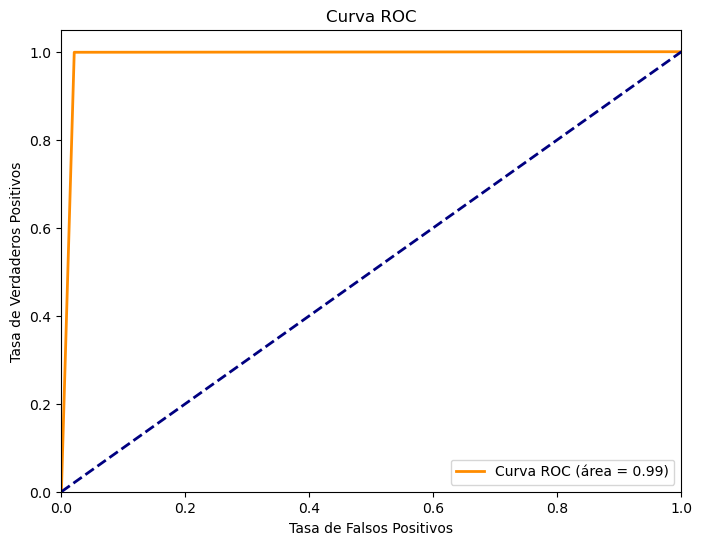

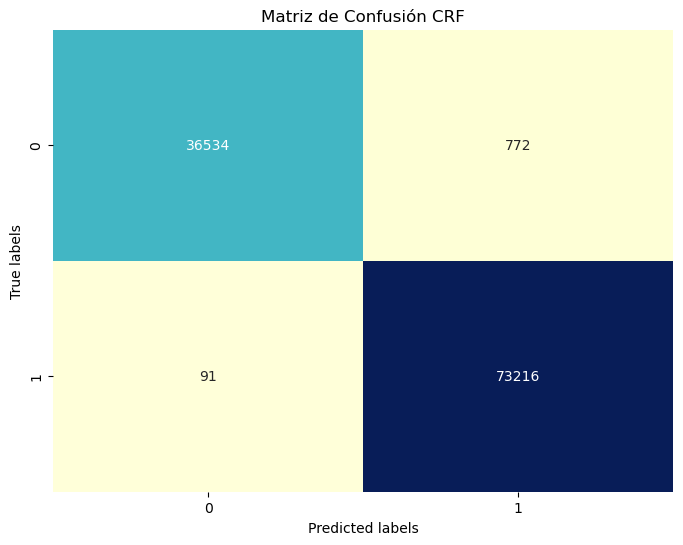

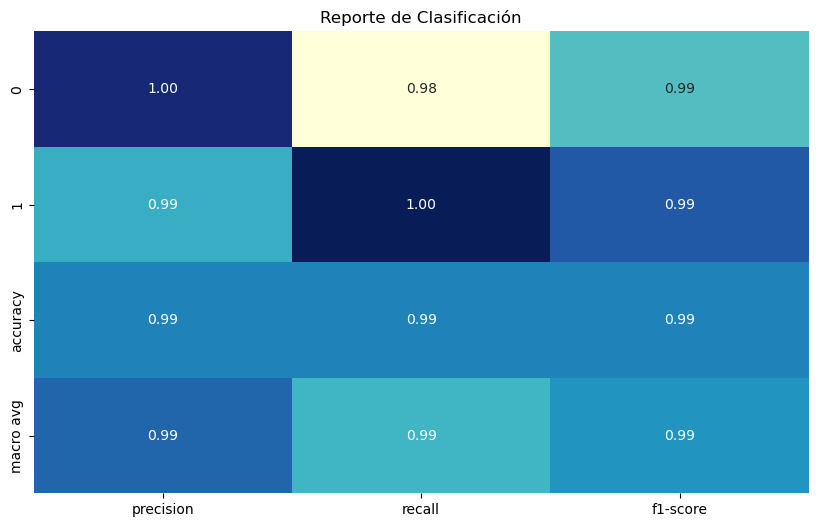

In [206]:
from sklearn_crfsuite import metrics
print(metrics.flat_classification_report(Y_test_sequences, y_pred))

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc

# Convertir las listas de listas en listas planas
y_test_flat = [label for sublist in Y_test_sequences for label in sublist]
y_pred_flat = [label for sublist in y_pred for label in sublist]

# Calcular la curva ROC y el AUC
fpr, tpr, _ = roc_curve([int(label) for label in y_test_flat], [int(label) for label in y_pred_flat])
roc_auc = auc(fpr, tpr)

# Mostrar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# Matriz de confusión
cm = confusion_matrix(y_test_flat, y_pred_flat)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.title('Matriz de Confusión CRF')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# Mostrar el reporte de clasificación
report = classification_report(y_test_flat, y_pred_flat, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Mostrar el reporte de clasificación con seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", cbar=False, fmt='.2f')
plt.title('Reporte de Clasificación')
plt.show()

## Pruebas con mis ejemplos de SQLi

In [197]:
# Ajustar los parámetros del modelo CRF
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.01,  # Ajustar el valor de c1
    c2=0.01,  # Ajustar el valor de c2
    max_iterations=200,  # Incrementar el número de iteraciones
    all_possible_transitions=True
)
crf.fit(X_train_features, Y_train_sequences)

# Evaluar el modelo nuevamente
y_pred = crf.predict(X_test_features)
print(metrics.flat_classification_report(Y_test_sequences, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.98      0.99     37306
           1       0.99      1.00      0.99     73307

    accuracy                           0.99    110613
   macro avg       0.99      0.99      0.99    110613
weighted avg       0.99      0.99      0.99    110613



In [198]:
# Ejemplos de sentencias SQL basadas en el archivo SQLiV3.csv
test_sentences = [
    " OR 1=1 --", # SQLi
    "admin' --",  # SQLi
    "user", # Benigna
    "admin", # Benigna
    "password", # Benigna
    "asdasdasdasd", # Benigna
    "'", # SQLi
    "AND (SELECT count(tbl_name) FROM sqlite_master WHERE type='table' AND tbl_name NOT LIKE 'sqlite_%' ) < number_of_table ", # SQLi
    "SELECT * FROM users WHERE id = 1",  # Benigna
    "SELECT * FROM users WHERE id = 1 OR 1=1",  # Benigna
    "SELECT * FROM users WHERE username = 'admin' --",  # Benigna
    "SELECT * FROM users WHERE username = 'admin' AND password = '' OR '1'='1'",  # Benigna
    "SELECT * FROM users WHERE id = 1 OR pg_sleep(10) --",  # Benigna
    "INSERT INTO users (username, password) VALUES ('admin', 'password')",  # Benigna
    "UPDATE users SET password = 'newpassword' WHERE id = 1",  # Benigna
    "1; (load_file(char(47,101,116,99,47,112,97,115,115,119,100))) ,1,1,1;",  # SQLi
]

# Tokenizar las sentencias
test_tokens = [word_tokenize(sentence) for sentence in test_sentences]

# Convertir las sentencias tokenizadas en secuencias de embeddings
test_embeddings = [sentence_to_embeddings(tokens) for tokens in test_tokens]

# Convertir las secuencias de embeddings en un formato que el modelo CRF pueda manejar
test_features = [convert_embeddings_to_features(embeddings) for embeddings in test_embeddings]

# Predecir las etiquetas utilizando el modelo CRF
test_predictions = crf.predict(test_features)

# Mostrar los resultados
for sentence, prediction in zip(test_sentences, test_predictions):
    print(f"Sentence: {sentence}")
    print(f"Prediction: {prediction}")
    print()

Sentence:  OR 1=1 --
Prediction: ['1', '1']

Sentence: admin' --
Prediction: ['1', '1', '1']

Sentence: user
Prediction: ['1']

Sentence: admin
Prediction: ['1']

Sentence: password
Prediction: ['1']

Sentence: asdasdasdasd
Prediction: []

Sentence: '
Prediction: ['1']

Sentence: AND (SELECT count(tbl_name) FROM sqlite_master WHERE type='table' AND tbl_name NOT LIKE 'sqlite_%' ) < number_of_table 
Prediction: ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1']

Sentence: SELECT * FROM users WHERE id = 1
Prediction: ['0', '0', '0', '0', '0', '0', '0', '0']

Sentence: SELECT * FROM users WHERE id = 1 OR 1=1
Prediction: ['0', '0', '0', '0', '0', '0', '0', '0', '0']

Sentence: SELECT * FROM users WHERE username = 'admin' --
Prediction: ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0']

Sentence: SELECT * FROM users WHERE username = 'admin' AND password = '' OR '1'='1'
Prediction: ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', 